## Book Genre Classification using RNNs and LSTM

In this notebook, we'll be looking at how to apply deep learning techniques to classify books using just their titles. Text Classification can be thought of as the exercise of taking a sentence, paragraph, document and determining what kind it belongs it like in case of sentiment analysis it could be sad, happy or positive, negative. 

This notebook will go through numerous topics like word vectors, recurrent neural networks, and long short-term memory units (LSTMs). After getting a good understanding of these terms, we’ll walk through concrete code examples and a full Tensorflow sentiment classifier at the end.

Using an RNN rather than a feedfoward network is more accurate since we can include information about the sequence of words.

In order to understand how deep learning can be applied, think about all the different forms of data that are used as inputs into machine learning or deep learning models. Convolutional neural networks use arrays of pixel values, logistic regression uses quantifiable features, and reinforcement learning models use reward signals. The common theme is that the inputs need to be scalar values, or matrices of scalar values. When you think of NLP tasks, however, a data pipeline like this may come to mind. 

We want these vectors to be created in such a way that they somehow represent the word and its context, meaning, and semantics. For example, we’d like the vectors for the words “love” and “adore” to reside in relatively the same area in the vector space since they both have similar definitions and are both used in similar contexts. The vector representation of a word is also known as a word embedding.

![caption](assets/vectors.png)


Loading our dependencies

In [1]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf

To create vectors for book titles, we're going to be using a pretrained model. 

For this task, we'll be using a much more manageable matrix that is trained using [GloVe](http://nlp.stanford.edu/projects/glove/), a similar word vector generation model. The matrix will contain 400,000 word vectors, each with a dimensionality of 50. 

We're going to be importing two different data structures, one will be a Python list with the 400,000 words, and one will be a 400,000 x 50 dimensional embedding matrix that holds all of the word vector values. 

Here, we'll pass in words to an embedding layer. We need an embedding layer because we have tens of thousands of words, so we'll need a more efficient representation for our input data than one-hot encoded vectors.

From the embedding layer, the new representations will be passed to LSTM cells. These will add recurrent connections to the network so we can include information about the sequence of words in the data. Finally, the LSTM cells will go to a sigmoid output layer here.

In [2]:
wordsList = np.load('wordsList.npy')
print('Loaded the word list!')
wordsList = wordsList.tolist() #Originally loaded as numpy array
wordsList = [word.decode('UTF-8') for word in wordsList] #Encode words as UTF-8
wordVectors = np.load('wordVectors.npy')
print ('Loaded the word vectors!')

Loaded the word list!
Loaded the word vectors!


In [5]:
print (wordsList[:100])
print (len(wordsList))

['0', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as', 'it', 'by', 'at', '(', ')', 'from', 'his', "''", '``', 'an', 'be', 'has', 'are', 'have', 'but', 'were', 'not', 'this', 'who', 'they', 'had', 'i', 'which', 'will', 'their', ':', 'or', 'its', 'one', 'after', 'new', 'been', 'also', 'we', 'would', 'two', 'more', "'", 'first', 'about', 'up', 'when', 'year', 'there', 'all', '--', 'out', 'she', 'other', 'people', "n't", 'her', 'percent', 'than', 'over', 'into', 'last', 'some', 'government', 'time', '$', 'you', 'years', 'if', 'no', 'world', 'can', 'three', 'do', ';', 'president', 'only', 'state', 'million', 'could', 'us', 'most', '_', 'against', 'u.s.']
400000


In [11]:
print (wordVectors[88])
print (wordVectors.shape)

[  2.96050012e-01  -1.38410002e-01   4.37740013e-02  -3.87439996e-01
   1.22620001e-01  -6.51799977e-01  -2.82400012e-01   9.03119966e-02
  -5.51859975e-01   3.20600003e-01   3.74220009e-03   9.32290018e-01
  -2.20339999e-01  -2.19219998e-01   9.21700001e-01   7.57239997e-01
   8.48919988e-01  -4.21970012e-03   5.36260009e-01  -1.26670003e+00
  -6.10279977e-01   1.66999996e-01   8.27530026e-01   6.57649994e-01
   4.89589989e-01  -1.97440004e+00  -1.14900005e+00  -2.14609995e-01
   8.05390000e-01  -1.47449994e+00   3.74900007e+00   1.01409996e+00
  -1.12930000e+00  -5.26610017e-01  -1.20290004e-01  -2.79309988e-01
   6.50919974e-02  -4.36390005e-02   6.04260027e-01  -2.08920002e-01
  -4.57390010e-01   1.04409996e-02   4.14579988e-01   6.89000010e-01
   1.44679993e-01  -3.19730006e-02  -4.80730012e-02  -1.12790003e-04
   1.38540000e-01   9.69540000e-01]
(400000, 50)


### Loading the dataset

In [12]:
data = pd.read_csv('data/book32-listing.csv',encoding = "ISO-8859-1")

In [13]:
columns = ['Id', 'Image', 'Image_link', 'Title', 'Author', 'Class', 'Genre']
data.columns = columns

In [14]:
books = pd.DataFrame(data['Title'])
author = pd.DataFrame(data['Author'])
genre = pd.DataFrame(data['Genre'])

In [15]:
books.head()

,Title
0,Doug the Pug 2016 Wall Calendar
1,"Moleskine 2016 Weekly Notebook, 12M, Large, Bl..."
2,365 Cats Color Page-A-Day Calendar 2016
3,Sierra Club Engagement Calendar 2016
4,Sierra Club Wilderness Calendar 2016


In [16]:
genre.head()

,Genre
0,Calendars
1,Calendars
2,Calendars
3,Calendars
4,Calendars


In [17]:
print (len((genre['Genre'].unique())))
print ((genre['Genre'].unique()))

32
['Calendars' 'Comics & Graphic Novels' 'Test Preparation'
 'Mystery, Thriller & Suspense' 'Science Fiction & Fantasy' 'Romance'
 'Humor & Entertainment' 'Literature & Fiction' 'Gay & Lesbian'
 'Engineering & Transportation' 'Cookbooks, Food & Wine'
 'Crafts, Hobbies & Home' 'Arts & Photography' 'Education & Teaching'
 'Parenting & Relationships' 'Self-Help' 'Computers & Technology'
 'Medical Books' 'Science & Math' 'Health, Fitness & Dieting'
 'Business & Money' 'Law' 'Biographies & Memoirs' 'History'
 'Politics & Social Sciences' 'Reference' 'Christian Books & Bibles'
 'Religion & Spirituality' 'Sports & Outdoors' 'Teen & Young Adult'
 "Children's Books" 'Travel']


In [18]:
numBooks =  (len(books))
numGenres =  (len(genre))
print (numBooks)
print (numGenres)

207571
207571


In [34]:
aWordIndex = wordsList.index('messi')
print (aWordIndex)
print (wordVectors[aWordIndex])
print (wordVectors[aWordIndex].shape)

19087
[ 0.24808     0.032891   -0.062788   -0.45602    -0.15155999 -0.66189998
 -0.51319999 -0.092383   -0.67546999  1.94749999  1.13080001  0.94336998
 -0.90491003  0.18035001  1.11570001 -0.32481     0.44242001 -0.46054
 -1.19659996 -0.17732    -1.7263      0.5043     -0.28464001 -0.45795
  0.33803999 -0.13706     1.20309997  0.34261    -0.58967    -0.70613003
  0.62695998  0.76880997 -0.46966001 -0.081293    0.39987001  0.89332002
  0.40821001  0.73082     0.077319   -0.81061     0.61938     0.95126998
 -0.20062999 -0.19441    -0.70710999  0.093774    0.99932998  0.05538
  0.20422    -1.36650002]
(50,)


Now that we have our vectors, our first step is taking an input sentence and then constructing its vector representation. Let's say that we have the input sentence "I thought the movie was incredible and inspiring". In order to get the word vectors, we can use Tensorflow's embedding lookup function.

This function takes in two arguments, one for the embedding matrix (the wordVectors matrix in our case), and one for the ids of each of the words. The ids vector can be thought of as the integerized representation of the training set. This is basically just the row index of each of the words.

In [41]:
import tensorflow as tf
maxSeqLength = 10 #Maximum length of sentence
numDimensions = 300 #Dimensions for each word vector
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("too")
firstSentence[2] = wordsList.index("had")
firstSentence[3] = wordsList.index("a")
firstSentence[4] = wordsList.index("love")
firstSentence[5] = wordsList.index("story")
#firstSentence[6] = wordsList.index("k")
#firstSentence[7] = wordsList.index("ki")
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

(10,)
[ 41 317  40   7 835 523   0   0   0   0]


In [45]:
with tf.Session() as sess:
    print("Word vector for a single word", tf.nn.embedding_lookup(wordVectors, firstSentence).eval()[0])
    print("\n")
    print("Dimension for a single word", tf.nn.embedding_lookup(wordVectors, firstSentence).eval()[0].shape)
    print ('\n')
    print("Shape of the vector for this sentence", tf.nn.embedding_lookup(wordVectors, firstSentence).eval().shape)
    print ("\n")
    print("Vector for this sentence", tf.nn.embedding_lookup(wordVectors, firstSentence).eval())

Word vector for a single word [  1.18910000e-01   1.52549997e-01  -8.20730031e-02  -7.41439998e-01
   7.59169996e-01  -4.83280003e-01  -3.10090005e-01   5.14760017e-01
  -9.87079978e-01   6.17570011e-04  -1.50429994e-01   8.37700009e-01
  -1.07969999e+00  -5.14599979e-01   1.31879997e+00   6.20069981e-01
   1.37789994e-01   4.71080005e-01  -7.28740022e-02  -7.26750016e-01
  -7.41159976e-01   7.52629995e-01   8.81799996e-01   2.95610011e-01
   1.35479999e+00  -2.57010007e+00  -1.35230005e+00   4.58799988e-01
   1.00680006e+00  -1.18560004e+00   3.47370005e+00   7.78980017e-01
  -7.29290009e-01   2.51020014e-01  -2.61559993e-01  -3.46839994e-01
   5.58409989e-01   7.50980020e-01   4.98299986e-01  -2.68229991e-01
  -2.74430006e-03  -1.82980001e-02  -2.80959994e-01   5.53179979e-01
   3.77059989e-02   1.85550004e-01  -1.50250003e-01  -5.75119972e-01
  -2.66710013e-01   9.21209991e-01]


Dimension for a single word (50,)


Shape of the vector for this sentence (10, 50)


Vector for this sen

Data Pipeline

![caption](assets/pipeline.png)

### Basic dataset Exploration

In [46]:
numWords = []
for i,j in enumerate(books['Title']):
    counter = len(j.split())
    numWords.append(counter)       

In [47]:
print('The total number of words in all books is', sum(numWords))
print('The average number of words in the each book title is', sum(numWords)/len(numWords))

The total number of words in all books is 1900083
The average number of words in the each book title is 9.153894330132822


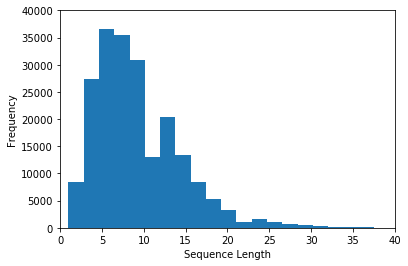

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 40)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 40, 0, 40000])
plt.show()

From the histogram as well as the average number of words, book title are 10 words, which is less than max sequence length value we will set. 

In [49]:
# Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [50]:
print (books['Title'][0])
print (cleanSentences(books['Title'][0]))
print ('\n')
print (books['Title'][100000])
print (cleanSentences(books['Title'][100000]))
print ('\n')
print (books['Title'][33330])
print (cleanSentences(books['Title'][33330]))
print ('\n')
print (books['Title'][8889])
print (cleanSentences(books['Title'][8889]))
print ('\n')
print (books['Title'][70000])
print (cleanSentences(books['Title'][70000]))
print ('\n')
print (books['Title'][200000])
print (cleanSentences(books['Title'][200000]))

Doug the Pug 2016 Wall Calendar
doug the pug 2016 wall calendar


Face Reading in Chinese Medicine, 2e
face reading in chinese medicine 2e


Bare-Bones Meditation: Waking Up from the Story of My Life
barebones meditation waking up from the story of my life


The Last Taxi Ride: A Ranjit Singh Novel
the last taxi ride a ranjit singh novel


CCNA Routing and Switching ICND2 200-101 Official Cert Guide
ccna routing and switching icnd2 200101 official cert guide


City Secrets Paris: The Essential Insider's Guide
city secrets paris the essential insiders guide


We will keep our vector sequence length equal to 20.

In [51]:
maxSeqLength = 20

In [34]:
%%time
features = np.zeros((numBooks, maxSeqLength), dtype='int32')

fileCounter = 0

for i,j in enumerate(books['Title']): 
    indexCounter = 0
    cleanedLine = cleanSentences(j)
    split = cleanedLine.split()
    for word in split:
        try:
            features[fileCounter][indexCounter] = wordsList.index(word)
        except ValueError:
            features[fileCounter][indexCounter] = 399999 #Vector for unkown words
        indexCounter = indexCounter + 1
        if indexCounter >= maxSeqLength:
            break
    fileCounter = fileCounter + 1 

np.save('features/idsMatrix20', features)

CPU times: user 18min 5s, sys: 6.11 s, total: 18min 11s
Wall time: 18min 25s


We have already created idMatrices for sequences 10,20 and 50. You can choose different matrix for experiemtnal purpose

In [52]:
features = np.load('features/idsMatrix20.npy')

In [53]:
features.shape

(207571, 20)

First Book title from our dataset

In [54]:
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("doug")
firstSentence[1] = wordsList.index("the")
firstSentence[2] = wordsList.index("pug")
firstSentence[3] = wordsList.index("2016")
firstSentence[4] = wordsList.index("wall")
firstSentence[5] = wordsList.index("calendar")
print(firstSentence) #Shows the row index for each word

[  6406 201534  65579  15463   1015   5657      0      0      0      0
      0      0      0      0      0      0      0      0      0      0]


In [55]:
print (books['Title'][0])
features[0]

Doug the Pug 2016 Wall Calendar


array([  6406, 201534,  65579,  15463,   1015,   5657,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0], dtype=int32)

Converting genres(labels) using LabelEncoder and keras' to_categorical function

In [56]:
from sklearn.preprocessing import LabelEncoder

feat = ['Genre']
for x in feat:
    le = LabelEncoder()
    le.fit(list(genre[x].values))
    genre[x] = le.transform(list(genre[x]))

In [57]:
from keras.utils.np_utils import to_categorical
target = to_categorical(genre['Genre'], 32)

Using TensorFlow backend.


In [58]:
target.shape

(207571, 32)

## Splitting into training and test set

In [59]:
from sklearn.cross_validation import train_test_split 

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [60]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.10)

In [61]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(186813, 20)
(186813, 32)
(20758, 20)
(20758, 32)


### Defining out hyperparameters

Choosing the right values for your hyperparameters is a crucial part of training deep neural networks effectively. You'll find that your training loss curves can vary with your choice of optimizer (Adam, Adadelta, SGD, etc), learning rate, and network architecture. With RNNs and LSTMs in particular, some other important factors include the number of LSTM units and the size of the word vectors.

* Learning Rate: RNNs are infamous for being diffult to train because of the large number of time steps they have. Learning rate becomes extremely important since we don't want our weight values to fluctuate wildly as a result of a large learning rate, nor do we want a slow training process due to a low learning rate. The default value of 0.001 is a good place to start. You should increase this value if the training loss is changing very slowly, and decrease if the loss is unstable.  
* Optimizer: There isn't a consensus choice among researchers, but Adam has been widely popular due to having the adaptive learning rate property (Keep in mind that optimal learning rates can differ with the choice of optimizer).
* Number of LSTM units: This value is largely dependent on the average length of your input texts. While a greater number of units provides more expressibility for the model and allows the model to store more information for longer texts, the network will take longer to train and will be computationally expensive. 
* Word Vector Size: Dimensions for word vectors generally range from 50 to 300. A larger size means that the vector is able to encapsulate more information about the word, but you should also expect a more computationally expensive model. 

In [62]:
batchSize = 64
lstmUnits = 2
numClasses = 32
iterations = 10
numDimensions = 20

Helper Function to get batches

In [63]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

## Model

Defining Placeholders for input and labels

In [64]:
tf.reset_default_graph()

labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])


#### Embedding
Now we'll add an embedding layer. We need to do this because there are 1900083 words in our vocabulary. It is massively inefficient to one-hot encode our classes here. Instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table.


In [65]:
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)
data = tf.nn.embedding_lookup(wordVectors, input_data)

Next, we'll create our LSTM cells to use in the recurrent network (TensorFlow documentation). Here we are just defining what the cells look like. This isn't actually building the graph, just defining the type of cells we want in our graph.

The tf.nn.rnn_cell.BasicLSTMCell  function takes in an integer for the number of LSTM units that we want. This is one of the hyperparameters that will take some tuning to figure out the optimal value. We’ll then wrap that LSTM cell in a dropout layer to help prevent the network from overfitting.

In [66]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.50)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

The first output of the dynamic RNN function can be thought of as the last hidden state vector. This vector will be reshaped and then multiplied by a final weight matrix and a bias term to obtain the final output values.

In [67]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

Next, we’ll define correct prediction and accuracy metrics to track how the network is doing. The correct prediction formulation works by looking at the index of the maximum value of the 2 output values, and then seeing whether it matches with the training labels. 

In [68]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

Calculating loss and defining optimizer

In [71]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

### Training 

In [72]:
%%time
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

for i in range(iterations):
    #Next Batch of reviews
    for ii, (x, y) in enumerate(get_batches(X_train, y_train, batch_size = batchSize)):
        sess.run(optimizer, {input_data: x, labels: y})
        #acc,loss = sess.run([accuracy,loss], {input_data: x, labels: y})
    print("Loss for {} epoch: {}".format(i, (sess.run(loss, {input_data: x, labels: y}))))    
    print("Accuracy for {} epoch: {}".format(i, (sess.run(accuracy, {input_data: x, labels: y})) * 100))
    
save_path = saver.save(sess, "models/test.ckpt", global_step=i)    

Loss for 0 epoch: 3.114346504211426
Accuracy for 0 epoch: 10.9375
CPU times: user 1min 35s, sys: 1min 18s, total: 2min 54s
Wall time: 1min 37s


In [43]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint('models'))

### Testing

In [46]:
for i in range(iterations):
    for ii, (x, y) in enumerate(get_batches(X_test, y_test, batch_size = batchSize)):
        if (ii % 30000 ==0):
            print ("Accuracy for {} epoch: {}".format(i, (sess.run(accuracy, {input_data: x, labels: y})) * 100))

Accuracy for 0 epoch: 56.00000023841858
Accuracy for 1 epoch: 58.99999737739563
Accuracy for 2 epoch: 60.00000238418579
Accuracy for 3 epoch: 58.99999737739563
Accuracy for 4 epoch: 62.99999952316284
Accuracy for 5 epoch: 60.00000238418579
Accuracy for 6 epoch: 57.999998331069946
Accuracy for 7 epoch: 60.00000238418579
Accuracy for 8 epoch: 57.999998331069946
Accuracy for 9 epoch: 55.000001192092896
Accuracy for 10 epoch: 60.00000238418579
Accuracy for 11 epoch: 56.00000023841858
Accuracy for 12 epoch: 57.999998331069946
Accuracy for 13 epoch: 58.99999737739563
Accuracy for 14 epoch: 61.000001430511475
Accuracy for 15 epoch: 62.00000047683716
Accuracy for 16 epoch: 61.000001430511475
Accuracy for 17 epoch: 58.99999737739563
Accuracy for 18 epoch: 60.00000238418579
Accuracy for 19 epoch: 57.999998331069946
